# Wav2Vec 2.0

In [11]:
import torch
from torchaudio.datasets import LIBRISPEECH
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.loss import _Loss
import numpy as np

## Feature Encoder

In [12]:
class TransposeLastDim(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return x.transpose(-2, -1)

class FeatureEncoderBlock(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, drop_prob, activation):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.kernel_size = kernel_size
        self.activation = activation
        self.conv_bloc = nn.Sequential(
            nn.Conv1d(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride),
            nn.Dropout(p=drop_prob),
            TransposeLastDim(),
            nn.LayerNorm(normalized_shape=out_channel),
            TransposeLastDim(),
            activation
        )
        
    def forward(self, x):
        return self.conv_bloc(x)

class FeatureEncoder(nn.Module):
    def __init__(
        self,
        n_blocks,
        dim,
        kernel_sizes,
        strides,
        p,
        with_mask,
        mask_span,
        drop_prob,
        activation='gelu'
    ):
        super().__init__()
        self.dim = dim
        self.kernel_sizes = kernel_sizes
        self.strides = strides
        self.p = p
        self.with_mask = with_mask
        self.mask_span = mask_span
        self.mask_vector = nn.Parameter(torch.FloatTensor(dim).uniform_()) if with_mask else None
        self.drop_prob = drop_prob
        self.activation = nn.GELU()
        self.conv_blocks = nn.ModuleList()
        assert len(kernel_sizes) == n_blocks, "Invalid arguments: block_kernel_sizes must have length n_blocks"
        assert len(strides) == n_blocks, "Invalid arguments: block_strides must have length n_blocks"
        in_channel = 1
        for (kernel_size, stride) in zip(kernel_sizes, strides):
            self.conv_blocks.append(
                FeatureEncoderBlock(
                    in_channel=in_channel,
                    out_channel=dim,
                    kernel_size=kernel_size,
                    stride=stride,
                    drop_prob=drop_prob,
                    activation=self.activation
                )
            )
            in_channel = dim
        
        
    def forward(self, x):
        # x is a raw audio waveform of shape (B, T)
        # reshaping it to (B, 1, T)
        B, T = x.shape
        x = x.unsqueeze(1)
        for conv_block in self.conv_blocks:
            x = conv_block(x)
        
        if self.with_mask:
            with torch.no_grad():
                num_samples = int(self.p*T)
                indices = torch.arange(T).float()
                start_ids = torch.multinomial(indices, num_samples).to(torch.long)
                masked_x = x.clone()
                mask = torch.full(x.shape, False)
                for idx in start_ids:
                    masked_x[:,:,idx:(idx+self.mask_span)%T] = 0
                    masked_x[:,:,idx:(idx+self.mask_span)%T] += self.mask_vector.unsqueeze(0).unsqueeze(-1)
                    mask[:,:,idx:(idx+self.mask_span)%T] = True

                result = {
                    "x": x,
                    "masked_x": masked_x,
                    "mask": mask
                }
            
            return result
        else:
            return x

## RelativePositionalEmbedding

In [13]:
class LengthCorrection(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x[:, :, :-1]

class RelativePositionalEmbedding(nn.Module):
    """ A CNN used as relative positional embedding
    """
    def __init__(self, embed_dim, kernel_size, padding, groups):
        super().__init__()
        self.embed_dim = embed_dim
        self.kernel_size = kernel_size
        self.padding = padding
        self.groups = groups
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=embed_dim, out_channels=embed_dim, kernel_size=kernel_size, padding=padding, groups=groups),
            LengthCorrection(),
            TransposeLastDim(),
            nn.LayerNorm(normalized_shape=embed_dim),
            TransposeLastDim(),
            nn.GELU()
        )
    
    def forward(self, x):
        # x has shape (B, C, T)
        x = self.conv(x)
        return x

## ProductQuantizer

In [14]:
class ProductQuantizer(nn.Module):
    def __init__(self, z_dim, n_groups, n_entries, q_dim, temperature=1.):
        super().__init__()
        self.z_dim = z_dim
        self.n_groups = n_groups
        self.n_entries = n_entries
        self.q_dim = q_dim
        assert q_dim % n_groups == 0, f"Invalid arguments: q_dim must be divisable by n_groups. Got z_dim={z_dim}, n_groups={n_groups}"
        self.v_dim = q_dim // n_groups
        self.temperature = temperature
        self.codevectors = nn.Parameter(torch.FloatTensor(1, n_groups*n_entries, self.v_dim))
        self.proj = nn.Linear(in_features=z_dim, out_features=n_groups*n_entries)
    
    def forward(self, x):
        # x has shape (B, C, T)
        x = x.transpose(-2, -1) # now x has shape (B, T, C)
        B, T, C = x.shape
        x = self.proj(x) # (B, T, n_groups*n_entries)
        
        result = {"codebook_logits": x.view(B, T, self.n_groups, -1)}
        x = x.view(B*T*self.n_groups, -1)
        x = F.gumbel_softmax(x.float(), tau=self.temperature, hard=True)
        x = x.view(B*T, -1).unsqueeze(-1)
        x = x * self.codevectors
        x = x.view(B*T, self.n_groups, self.n_entries, -1)
        x = x.sum(axis=-2)
        x = x.view(B, T, -1)
        result["q"] = x
        
        return result

## TransformerEncoder

In [15]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, d_model, num_heads, dff, drop_prob, activation):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, dropout=drop_prob)
        self.dffn = nn.Sequential(
            nn.Linear(in_features=embed_dim, out_features=dff),
            activation,
            nn.Linear(in_features=dff, out_features=d_model)
        )
        self.norm1 = nn.LayerNorm(normalized_shape=embed_dim)
        self.norm2 = nn.LayerNorm(normalized_shape=d_model)
        self.dropout = nn.Dropout(drop_prob)
        
    def forward(self, x):
        x = self.norm1(x + self.attention(x, x, x)[0])
        x = self.norm2(x + self.dropout(self.dffn(x)))
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, d_model, num_heads, dff, num_layers, drop_prob, activation='relu'):
        super().__init__()
        self.embed_dim = embed_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.dff = dff
        self.num_layers = num_layers
        self.drop_prob = drop_prob
        self.activation = nn.ReLU()
        
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, d_model, num_heads, dff, drop_prob, self.activation)
            if i == 0 else
            TransformerEncoderLayer(d_model, d_model, num_heads, dff, drop_prob, self.activation)
            for i in range(num_layers)
        ])
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

## Wav2Vec2Model

In [16]:
class Wav2Vec2Model(nn.Module):
    def __init__(
        self,
        fe_n_blocks,
        fe_dim,
        fe_kernel_sizes,
        fe_strides,
        p,
        with_mask,
        mask_span,
        drop_prob,
        rpe_kernel_size,
        rpe_groups,
        qt_n_groups,
        qt_n_entries,
        final_dim,
        temperature,
        tfe_dff,
        tfe_num_heads,
        tfe_num_layers,
        tfe_activation='relu',
        activation='gelu'
    ):
        super().__init__()
        self.with_mask = with_mask
        self.mask_span = mask_span
        self.drop_prob = drop_prob
        
        self.feature_encoder = FeatureEncoder(
            n_blocks=fe_n_blocks,
            dim=fe_dim,
            kernel_sizes=fe_kernel_sizes,
            strides=fe_strides,
            p=p,
            with_mask=with_mask,
            mask_span=mask_span,
            drop_prob=drop_prob,
            activation=activation
        )
        
        self.post_extract_proj = nn.Linear(in_features=fe_dim, out_features=final_dim) if fe_dim != final_dim else None
        
        self.positional_embedding = RelativePositionalEmbedding(
            embed_dim=fe_dim if fe_dim == final_dim else final_dim,
            kernel_size=rpe_kernel_size,
            padding=rpe_kernel_size // 2,
            groups=rpe_groups
        )
        
        self.quantizer = ProductQuantizer(
            z_dim=fe_dim,
            n_groups=qt_n_groups,
            n_entries=qt_n_entries,
            q_dim=final_dim,
            temperature=temperature
        )
        
        self.transformer_encoder = TransformerEncoder(
            embed_dim=final_dim,
            d_model=final_dim,
            num_heads=tfe_num_heads,
            dff=tfe_dff,
            num_layers=tfe_num_layers,
            drop_prob=drop_prob,
            activation=tfe_activation
        )
        
        self.norm = nn.LayerNorm(fe_dim if fe_dim == final_dim else final_dim)
        
    def forward(self, src):
        if self.with_mask:
            result = self.feature_encoder(src)
            features = result['masked_x']
            unmasked_features = result['x']
            mask = result['mask']
        else:
            features = self.feature_encoder(src)
            unmasked_features = None
        
        if self.post_extract_proj is not None:
            features = self.post_extract_proj(features.transpose(-2, -1)).transpose(-2, -1)
        
        #print(f"features shape: {features.shape}")
        pos_emb = self.positional_embedding(features).transpose(-2, -1)
        x = self.norm(features.transpose(-2, -1) + pos_emb) # (B, T, C)
        quantizer_result = self.quantizer(unmasked_features if unmasked_features is not None else features)
        #y = quantizer
        
        x = self.transformer_encoder(x) # (B, T, C)
        #y = y.transpose(-2, -1)
        mask = mask.transpose(-2, -1)
        
        return {
            "x": x,
            "y": quantizer_result["q"],
            "mask": mask,
            "codebook_logits": quantizer_result["codebook_logits"]
        }

## Contrastive Loss

In [17]:
class ContrastiveLoss(_Loss):
    def __init__(self, temperature, n_distractors):
        super().__init__()
        self.temperature = temperature
        self.n_distractors = n_distractors
        
    def forward(self, x, y):
        B, T, C = y.shape
        
        with torch.no_grad():
            y = y.view(B*T, -1)

            distractor_ids = torch.randint(low=0, high=T, size=(B,  self.n_distractors*T))
            distractors = y[distractor_ids.view(-1)].view(B, T,  self.n_distractors, C)
            distractors = distractors.permute(2, 0, 1, 3)
            y = y.view(B, T, C)
            targets = torch.cat((y.unsqueeze(0), distractors), dim=0)
        
        sims = F.cosine_similarity(x.unsqueeze(0), targets, dim=-1)/self.temperature # similarities within distractors and the true target
        sim = F.cosine_similarity(x, y, dim=-1)/self.temperature # similarity with the true target
        
        loss = -(sim.exp() / sims.exp().sum(dim=0)).log().mean()
        
        return loss

## Diversity Loss

In [18]:
class DiversityLoss(_Loss):
    def __init__(self):
        super().__init__()
    
    def forward(self, logits):
        # logits should be of shape (B, T, G, V)
        dist = torch.mean(torch.softmax(logits, dim=-1), dim=0)
        loss = (dist*torch.log(dist + 1e-7)).mean()
        return loss

## PretrainingLoss

In [19]:
class PretrainingLoss(_Loss):
    def __init__(self, alpha, temperature, n_distractors):
        super().__init__()
        self.alpha = alpha
        self.contrastive_loss = ContrastiveLoss(temperature, n_distractors)
        self.diversity_loss = DiversityLoss()
        
    def forward(self, x, y, logits):
        return self.contrastive_loss(x, y) + self.alpha * self.diversity_loss(logits)

## Loading an audio file for test

In [7]:
import wave
import numpy as np
import matplotlib.pyplot as plt

Number of channels: 1
Frame rate: 44100
Sample width: 2
Number of frames: 235520
Parameters at once: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=235520, comptype='NONE', compname='not compressed')
Audio duration: 5.34s


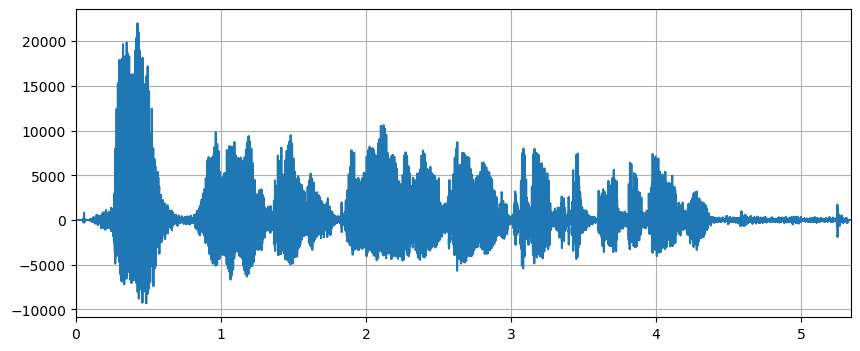

In [8]:
obj = wave.open("amadou.wav", "rb")

print(f"Number of channels: {obj.getnchannels()}")
print(f"Frame rate: {obj.getframerate()}")
print(f"Sample width: {obj.getsampwidth()}")
print(f"Number of frames: {obj.getnframes()}")
print(f"Parameters at once: {obj.getparams()}")

t_audio = obj.getnframes() / obj.getframerate()
print(f"Audio duration: {t_audio:.2f}s")

sample_fres = obj.getframerate()
n_samples = obj.getnframes()
signal_wave = obj.readframes(-1)
obj.close()

signal_array = np.frombuffer(signal_wave, np.int16)
times = np.linspace(0, t_audio, n_samples)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.plot(times, signal_array)
ax.set_xlim(0, t_audio)
ax.grid()

In [9]:
signal_array = torch.tensor(signal_array).float()

In [31]:
model = Wav2Vec2Model(
    fe_n_blocks=3,
    fe_dim=16,
    fe_kernel_sizes=[4, 4, 2],
    fe_strides=[1, 1, 1],
    p=0.063,
    with_mask=True,
    mask_span=4,
    drop_prob=0.05,
    rpe_kernel_size=4,
    rpe_groups=4,
    qt_n_groups=4,
    qt_n_entries=16,
    final_dim=16,
    temperature=1.3,
    tfe_dff=32,
    tfe_num_heads=2,
    tfe_num_layers=4,
    tfe_activation='relu',
    activation='gelu'
)

## Loading data

In [5]:
from torchaudio.datasets import LIBRISPEECH
from torch.utils.data import DataLoader

In [6]:
dataset = LIBRISPEECH(
    root='.'
)

In [7]:
dataloader = DataLoader(
    dataset,
    batch_size=1
)

In [8]:
sample = next(iter(dataloader))

In [9]:
sample

[tensor([[[-0.0065, -0.0055, -0.0062,  ...,  0.0033,  0.0005, -0.0095]]]),
 tensor([16000]),
 ('CHAPTER ONE MISSUS RACHEL LYNDE IS SURPRISED MISSUS RACHEL LYNDE LIVED JUST WHERE THE AVONLEA MAIN ROAD DIPPED DOWN INTO A LITTLE HOLLOW FRINGED WITH ALDERS AND LADIES EARDROPS AND TRAVERSED BY A BROOK',),
 tensor([103]),
 tensor([1240]),
 tensor([0])]

## Training

In [22]:
from torch.utils.data import Dataset, DataLoader

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os


def ddp_setup():
    init_process_group(backend="nccl")

class DistributedPreTrainer:
    def __init__(
        self,
        model: torch.nn.Module,
        train_data: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: _Loss,
        save_every: int,
        snapshot_path: str,
    ) -> None:
        self.gpu_id = int(os.environ["LOCAL_RANK"])
        self.model = model.to(self.gpu_id)
        self.train_data = train_data
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.save_every = save_every
        self.epochs_run = 0
        self.snapshot_path = snapshot_path
        if os.path.exists(snapshot_path):
            print("Loading snapshot")
            self._load_snapshot(snapshot_path)

        self.model = DDP(self.model, device_ids=[self.gpu_id])

    def _load_snapshot(self, snapshot_path):
        loc = f"mps:{self.gpu_id}"
        snapshot = torch.load(snapshot_path, map_location=loc)
        self.model.load_state_dict(snapshot["MODEL_STATE"])
        self.epochs_run = snapshot["EPOCHS_RUN"]
        print(f"Resuming training from snapshot at Epoch {self.epochs_run}")

    def _run_batch(self, batch):
        self.optimizer.zero_grad()
        output = self.model(batch)
        x = output['x']
        y = output['y']
        mask = output['mask']
        logits = output['codebook_logits']
        B, _, C = x.shape
        x = x[mask].view(B, -1, C)
        y = y[mask].view(B, -1, C)
        loss = self.loss_fn(x, y, logits)
        loss.backward()
        self.optimizer.step()

    def _run_epoch(self, epoch):
        b_sz = len(next(iter(self.train_data))[0])
        print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
        self.train_data.sampler.set_epoch(epoch)
        for batch in self.train_data:
            self._run_batch(batch.to(self.gpu_id))

    def _save_snapshot(self, epoch):
        snapshot = {
            "MODEL_STATE": self.model.module.state_dict(),
            "EPOCHS_RUN": epoch,
        }
        torch.save(snapshot, self.snapshot_path)
        print(f"Epoch {epoch} | Training snapshot saved at {self.snapshot_path}")

    def train(self, max_epochs: int):
        for epoch in range(self.epochs_run, max_epochs):
            self._run_epoch(epoch)
            if self.gpu_id == 0 and epoch % self.save_every == 0:
                self._save_snapshot(epoch)


def load_train_objs():
    dataset = LIBRISPEECH(root=".")
    model = Wav2Vec2Model(
        fe_n_blocks=3,
        fe_dim=16,
        fe_kernel_sizes=[4, 4, 2],
        fe_strides=[1, 1, 1],
        p=0.063,
        with_mask=True,
        mask_span=4,
        drop_prob=0.05,
        rpe_kernel_size=4,
        rpe_groups=4,
        qt_n_groups=4,
        qt_n_entries=16,
        final_dim=16,
        temperature=1.3,
        tfe_dff=32,
        tfe_num_heads=2,
        tfe_num_layers=4,
        tfe_activation='relu',
        activation='gelu'
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = PretrainingLoss()
    return dataset, model, optimizer, loss_fn


def prepare_dataloader(dataset: Dataset, batch_size: int):
    return DataLoader(
        dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        sampler=DistributedSampler(dataset)
    )


def main(save_every: int, total_epochs: int, batch_size: int, snapshot_path: str = "snapshot.pt"):
    ddp_setup()
    dataset, model, optimizer, loss_fn = load_train_objs()
    train_data = prepare_dataloader(dataset, batch_size)
    trainer = DistributedPreTrainer(model, train_data, optimizer, loss_fn, save_every, snapshot_path)
    trainer.train(total_epochs)
    destroy_process_group()